In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
import numpy as np
import os
import numpy as np
from scipy.stats import shapiro,mannwhitneyu,levene


# Mini-Project: Accuracy and Precision of RAPL-Based Energy Measurements
**Name:** [Student names]  
**Date:** [Submission date]  
**Course:** [Course name / code]


# 0. General Terms
This is a group assignment mini-project (you are allowed to hand-in individually). Please include data from all group members into the report  -you can as a group create the notebook, discuss validity, observations and data + conclusion. Between groups you may discuss conceptual aspects with your fellow students, but all analysis, code, and writing must be your own. Please write as concisely as possible — a well-written 2-page report is as appreciated as a 6-page report.

It is recommended that you prepare your report in a Jupyter Notebook.

#### Hand-in:
Submit your report and data to eksamen.ruc.dk (date and time on study.ruc.dk). 
If you encounter any issues or cannot hand-in on eksamen.ruc.dk, send Maja an email at majaht@ruc.dk before the deadline.

#### AI-based tools:
You may use AI-based software for this assignment. However, the report is subject to normal plagiarism rules: any text or program parts generated (or partly generated) by such tools must be clearly marked.

#### Requirements:
Throughout the assignment, specific requirements are stated. You may structure your report in any meaningful way, as long as all requirements are clearly satisfied.

You must hand in at least:
- Your combined dataset in CSV format
- Your report (e.g., a filled-out version of this Jupyter Notebook)
- all author names should be included in the each of the files

# 1. Introduction

In this mini-project, you will combine the data obtained from Assignment 1 (RAPL-based measurements) and Assignment 2 (external power supply measurements) to assess how accurately and precisely RAPL reflects actual energy consumption.



#### Overall Research Question:
**How accurate and precise are RAPL-based energy measurements compared to external power measurements, and does their performance depend on software characteristics?**

With *accuracy* and *precision* we mean:
- **Accuracy** is the *difference* (bias) between RAPL and external energy measurements.  
  - A high bias means RAPL systematically over- or underestimates total energy.
- **Precision** is the *variability* (e.g., standard deviation or variance) of repeated measurements using each method.  
  - Low variability means the method is stable and consistent across runs.

### Requirement 1.1.
Briefly introduce the project.  
- State the purpose of the comparison between RAPL and the external power supply.    
- State your overall research question and hypothesis.


#### More Precise Research Question:
**Do RAPL-based energy measurements differ systematically in mean or variance from external power measurements for CPU-bound and [your choice]-bound workloads?**

### Requirement 1.2 
In your report, state your Research Question, together with a precise null hypothesis and alternative hypothesis. You will need three hypothesis to cover the question. 




## 2. Data and Methodology

Describe:
- Which datasets you use (Assignment 1 and 2 results).  
- The variables:  
  - Independent: software characteristic (CPU / filesystem)  
  - Dependent: energy consumption  
  - Controlled: runtime, hardware, etc.  
- How you cleaned or filtered the data.




***Import of Data**

In [14]:
ls ..

Analysis/ External/ RAPL/


## Import the External Data from the External folder (Chunked Data)

In [28]:
#import all the CSV files for External measurements (Chunked Data)

input_directory = '../External'
# (a) Read from row 3 and on into df and calculate energy consumption
# (b) Read the first two lines with meta data, add the calculated energy consumption and concat to the existing
ID = 0
list_of_metadataframes = []
list_of_dataframes = []
for input_file in os.listdir(input_directory):
    file_path = input_directory+'/'
    file_name = os.path.basename(input_file)
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_path+file_name,skiprows=2, names=['timestamp','channel','action','payload'])
        df['time'] = (df['timestamp']-df['timestamp'].min()) / 1000
        df['ID'] = ID
        x = df['time']
        y = df['payload']
        y_int = integrate.cumulative_trapezoid(y, x, initial=0)

        energy = y_int[-1]
        df_main = pd.read_csv(file_path+file_name,nrows=1,header=0)
        df_main['duration']=df['time'].max() # in seconds
        df_main['energy']=energy  # in joules
        df_main['power_avg']= energy/df_main['duration'] # in Watt
        df_main['ID'] = ID
        df['class']=df_main['class'][0]
        df['ID'] = ID
        list_of_metadataframes.append(df_main)
        list_of_dataframes.append(df)
        ID = ID + 1

dfs = pd.concat(list_of_metadataframes)
df_powers = pd.concat(list_of_dataframes)
df_powers = df_powers.reset_index(drop=True)
dfs = dfs.sort_values(by='class')
dfs = dfs.reset_index(drop=True)


In [30]:
dfs.head(1) # contain both classes

,computerID,class,start_time,channelId,exp_duration,duration,energy,power_avg,ID
0,DK1081402,cpu,1761814761987,CH1,20322,20.307,564.354765,27.791144,0


In [32]:
dfs['method'] = 'External'
dfs = dfs.drop(columns=['start_time','channelId','duration','ID'])


In [34]:
# function to import the data from the tests
def import_data(filename):
    # read csv: outputs a datframe with 2 columns split by ";"
    df = pd.read_csv(filename, delimiter=";", decimal=".",  names=['test',"other"])

    # the "other" column contains all the test data and can be obtained by splitting with ","
    split_cols = df.iloc[:, 1].str.split(",", expand=True)
    
    # define columns and drop the useless ones "1", "2" and "other" from original dataframe
    split_cols.columns = ["CPU", "PKG", "1", "2", "time"]
    split_cols.drop(columns=["1", "2"], inplace=True)
    df.drop(columns="other", inplace=True)

    # convert the data to floats
    split_cols = split_cols.apply(pd.to_numeric, errors='coerce').astype('float64')
    
    # result is a concatenation the two
    df = pd.concat([df, split_cols], axis=1)
    
    return df

## Import the RAPL Data from the RAPL folder

In [37]:
# alter the name of your data files are csv (if the data is in a single file, remove the other)
file_name1 = '../RAPL/stress-ng-cpu.csv'
file_name2 = '../RAPL/stress-ng-filesystem.csv'

df_RAPL = pd.concat([import_data(file_name1),import_data(file_name2)])

print("RAPL tests")
print(df_RAPL.describe())



RAPL tests
                 CPU            PKG          time
count     800.000000     800.000000    800.000000
mean      138.265257     105.969863  21195.930750
std      9268.983266    9268.655477    912.493898
min   -261699.363281 -261722.747803  20214.500000
25%       446.190979     421.532120  20317.200000
50%       463.850281     426.975861  20882.650000
75%       481.849945     441.988754  21962.050000
max       897.318726     855.721680  25078.300000


In [39]:
df_RAPL["test"] = df_RAPL["test"].astype(str).str.strip()

df_RAPL  = df_RAPL[df_RAPL['PKG']>0]

In [41]:
dfs_RAPL = pd.DataFrame()
dfs_RAPL['class'] = df_RAPL['test']
dfs_RAPL['energy'] = df_RAPL['PKG']
dfs_RAPL['exp_duration'] = df_RAPL['time']
dfs_RAPL['computerID'] = dfs['computerID'][0]
dfs_RAPL['power_avg'] = dfs_RAPL['energy'] / (df_RAPL['time']/1000)
dfs_RAPL['method'] = "RAPL"



In [43]:
dfs_RAPL

,class,energy,exp_duration,computerID,power_avg,method
0,cpu,721.649841,20249.6,DK1081402,35.637733,RAPL
1,cpu,497.537903,20482.2,DK1081402,24.291234,RAPL
2,cpu,422.779175,20377.4,DK1081402,20.747454,RAPL
3,cpu,421.186157,20250.5,DK1081402,20.798803,RAPL
4,cpu,420.783325,20358.3,DK1081402,20.668883,RAPL
...,...,...,...,...,...,...
395,filesystem,425.678223,21051.5,DK1081402,20.220802,RAPL
396,filesystem,438.683838,21875.6,DK1081402,20.053568,RAPL
397,filesystem,436.116638,21837.5,DK1081402,19.970997,RAPL
398,filesystem,438.345764,21706.1,DK1081402,20.194589,RAPL


In [45]:
df = pd.concat([dfs,dfs_RAPL])
df = df.rename(columns={"class": "characteristica_class"})

In [47]:
# df.to_csv('data.csv')

### 2.1 Normalization


The experimental duration differs; we will normalize to 20 seconds to ensure energy values are comparable even if runtime differs between measurements.


In [50]:
# Normalize energy to 20 seconds (20,000 ms)
df["energy_norm20s"] = df["energy"] * (20000 / df["exp_duration"])


**Data is now imported**

## 2.2 First Glance at Data

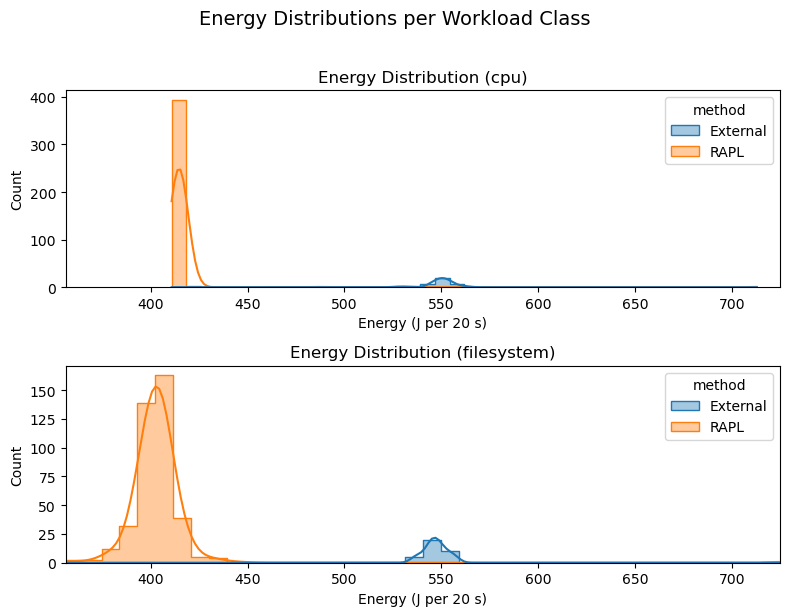

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

classes = df["characteristica_class"].unique()
n = len(classes)

# Find global min and max for consistent x-axis limits
xmin = df["energy_norm20s"].min()
xmax = df["energy_norm20s"].max()

plt.figure(figsize=(8, 3 * n))

for i, cls in enumerate(classes, 1):
    plt.subplot(n, 1, i)
    sns.histplot(
        data=df[df["characteristica_class"] == cls],
        x="energy_norm20s",
        hue="method",
        element="step",
        kde=True,
        bins=40,
        alpha=0.4
    )
    plt.title(f"Energy Distribution ({cls})")
    plt.xlabel("Energy (J per 20 s)")
    plt.ylabel("Count")
    plt.xlim(xmin, xmax)        # <-- keeps x-axis consistent

plt.suptitle("Energy Distributions per Workload Class", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## 3. Statistical Analysis


### 3.1 Normality Assessment (Assumption Testing)

In [58]:


# -----------------------------------------------------------
# Goal: Test whether normalized energy distributions are
#       normally distributed for each characteristica class and method.
# -----------------------------------------------------------

for (cls, method), subset in df.groupby(["characteristica_class", "method"]):
    stat, p = shapiro(subset["energy_norm20s"])
    print(f"{cls} - {method}: p = {p:.4f}")

    # --- Interpretation section ---
    if p < 0.05:
        print("  → The data deviates significantly from a normal distribution (p < 0.05).")
        print("  → Interpretation: The energy measurements are NOT normally distributed,")
    else:
        print("  → No significant deviation from normality (p ≥ 0.05).")
        print("  → Interpretation: The energy measurements are approximately normal,")


cpu - External: p = 0.0005
  → The data deviates significantly from a normal distribution (p < 0.05).
  → Interpretation: The energy measurements are NOT normally distributed,
cpu - RAPL: p = 0.0000
  → The data deviates significantly from a normal distribution (p < 0.05).
  → Interpretation: The energy measurements are NOT normally distributed,
filesystem - External: p = 0.6987
  → No significant deviation from normality (p ≥ 0.05).
  → Interpretation: The energy measurements are approximately normal,
filesystem - RAPL: p = 0.0000
  → The data deviates significantly from a normal distribution (p < 0.05).
  → Interpretation: The energy measurements are NOT normally distributed,


### 3.2 Accuracy of RAPL Measurements (Not normal distributions)

In [61]:
# Mann–Whitney U test comparing RAPL vs External (per software characteristica)
# Reports mean difference and p-values

# -----------------------------------------------------------
# Goal: Compare accuracy of RAPL vs External energy measurements
#       for each characteristica class using Mann–Whitney U test.
# 
# -----------------------------------------------------------

for cls in df["characteristica_class"].unique():
    data_ext = df[(df["characteristica_class"] == cls) & (df["method"] == "External")]["energy_norm20s"]
    data_rapl = df[(df["characteristica_class"] == cls) & (df["method"] == "RAPL")]["energy_norm20s"]
    stat, p = mannwhitneyu(data_ext, data_rapl, alternative="two-sided")
    print(f"{cls}: Mann–Whitney U p = {p:.4f}")

    # Compute mean difference (RAPL - External)
    diff = data_rapl.mean() - data_ext.mean()
    
    print(f"\n{cls.upper()}: Mann–Whitney U p = {p:.4f}, mean diff = {diff:.2f} J (RAPL - External)")
    
    # --- Interpretation section ---
    if p < 0.05:
        print("  → Significant difference between RAPL and External measurements (p < 0.05).")
        if diff < 0:
            print(f"  → RAPL reports LOWER energy than External by about {abs(diff):.1f} J.")
            print("  → Interpretation: RAPL underestimates total system energy consumption, "
                  "likely due to limited power-domain coverage (CPU only).")
        else:
            print(f"  → RAPL reports HIGHER energy than External by about {diff:.1f} J.")
            print("  → Interpretation: RAPL overestimates energy for this workload (rare).")
    else:
        print("  → No significant difference between RAPL and External (p ≥ 0.05).")
        print("  → Interpretation: RAPL provides comparable mean energy values for this workload.")


cpu: Mann–Whitney U p = 0.0000

CPU: Mann–Whitney U p = 0.0000, mean diff = -134.33 J (RAPL - External)
  → Significant difference between RAPL and External measurements (p < 0.05).
  → RAPL reports LOWER energy than External by about 134.3 J.
  → Interpretation: RAPL underestimates total system energy consumption, likely due to limited power-domain coverage (CPU only).
filesystem: Mann–Whitney U p = 0.0000

FILESYSTEM: Mann–Whitney U p = 0.0000, mean diff = -143.63 J (RAPL - External)
  → Significant difference between RAPL and External measurements (p < 0.05).
  → RAPL reports LOWER energy than External by about 143.6 J.
  → Interpretation: RAPL underestimates total system energy consumption, likely due to limited power-domain coverage (CPU only).


### 3.3 Precision of RAPL Measurements

In [64]:
# Levene’s test comparing variance between RAPL and External

# -----------------------------------------------------------
# Goal: Test whether RAPL and External measurements have
#       significantly different variances (precision check)
#       for each workload class.
# -----------------------------------------------------------

for cls in df["characteristica_class"].unique():
    data_ext = df[(df["characteristica_class"] == cls) & (df["method"] == "External")]["energy_norm20s"]
    data_rapl = df[(df["characteristica_class"] == cls) & (df["method"] == "RAPL")]["energy_norm20s"]

    # Levene’s test for equality of variances (center = "median" → robust to non-normality)
    stat, p = levene(data_ext, data_rapl, center="median")
    
    # Compute variance difference (RAPL - External)
    diff_var = data_rapl.var() - data_ext.var()
    
    print(f"\n{cls.upper()}: Levene’s test p = {p:.4f}, variance diff = {diff_var:.2f} (RAPL - External)")
    
    # --- Interpretation section ---
    if p < 0.05:
        print("  → Significant difference in measurement variance (p < 0.05).")
        if diff_var > 0:
            print(f"  → RAPL shows HIGHER variance, indicating lower precision "
                  f"(less consistent energy readings).")
        else:
            print(f"  → RAPL shows LOWER variance, indicating slightly higher precision.")
    else:
        print("  → No significant difference in measurement variance (p ≥ 0.05).")
        print("  → Interpretation: RAPL and External exhibit comparable precision.")
    



CPU: Levene’s test p = 0.3452, variance diff = 193.22 (RAPL - External)
  → No significant difference in measurement variance (p ≥ 0.05).
  → Interpretation: RAPL and External exhibit comparable precision.

FILESYSTEM: Levene’s test p = 0.2658, variance diff = 321.65 (RAPL - External)
  → No significant difference in measurement variance (p ≥ 0.05).
  → Interpretation: RAPL and External exhibit comparable precision.


### 3.4 Software Characteristica-Specific Effects

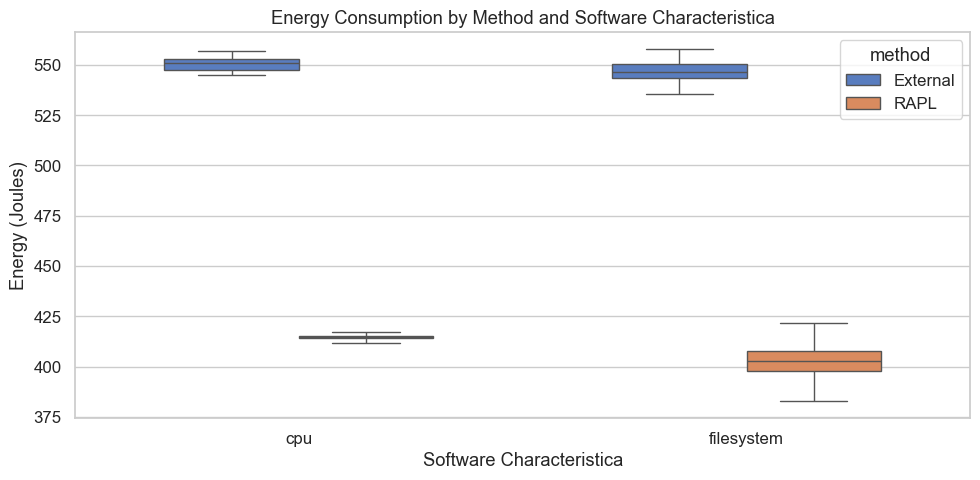

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x="characteristica_class", y="energy_norm20s", hue="method", showfliers=False, width=0.6)

plt.title("Energy Consumption by Method and Software Characteristica")
plt.xlabel("Software Characteristica")
plt.ylabel("Energy (Joules)")
plt.tight_layout()
plt.show()


For each method (External, RAPL), can we statistically see a significant difference in time-normalized energy between CPU and [your choice] 

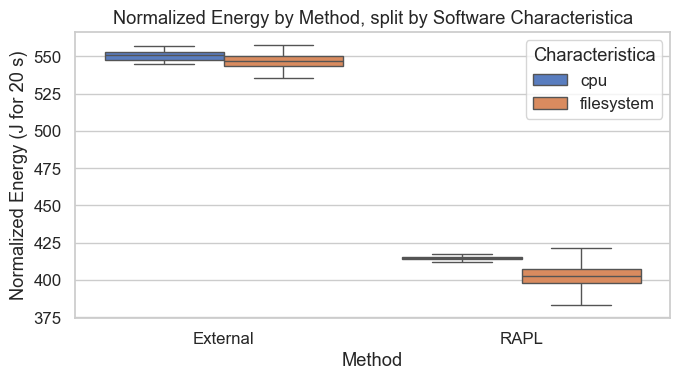

In [70]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=df,
    x="method", y="energy_norm20s",
    hue="characteristica_class",
    showfliers=False
)
plt.title("Normalized Energy by Method, split by Software Characteristica")
plt.xlabel("Method")
plt.ylabel("Normalized Energy (J for 20 s)")
plt.legend(title="Characteristica")
plt.tight_layout()
plt.show()


In [72]:

# ----------------------------------------------------------------------
# Goal: For each method (External, RAPL), test if CPU vs [your choice]
#       differ in normalized energy. This reveals workload-dependent bias.

from scipy.stats import mannwhitneyu

software_characteristica_A = "cpu"
software_characteristica_B = "filesystem"

def rank_biserial_from_u(u, n1, n2):
    # Rank-biserial correlation: r_rb = 1 - 2U/(n1*n2)
    return 1 - 2 * (u / (n1 * n2))

methods = df["method"].unique()

for method in methods:
    cpu = df[(df["characteristica_class"] == software_characteristica_A) & (df["method"] == method)]["energy_norm20s"]
    fs  = df[(df["characteristica_class"] == software_characteristica_B) & (df["method"] == method)]["energy_norm20s"]

    # Mann–Whitney U (non-parametric, robust to non-normality)
    stat, p = mannwhitneyu(cpu, fs, alternative="two-sided")
    diff = fs.mean() - cpu.mean()
    r_rb = rank_biserial_from_u(stat, len(cpu), len(fs))

    print(f"\nMethod = {method}")
    print(f"  Mann–Whitney U p = {p:.4f}")
    print(f"  Mean difference ({software_characteristica_B} - {software_characteristica_A}) = {diff:.2f} J")
    print(f"  Rank-biserial correlation (effect size) r_rb = {r_rb:.3f}")

    # Interpretation
    if p < 0.05:
        print(f"  → Significant {software_characteristica_A} vs {software_characteristica_B} difference within this method.")
        if diff < 0:
            print(f"  → {software_characteristica_B} appears LOWER than {software_characteristica_A} by ~{abs(diff):.1f} J.")
        else:
            print(f"  → {software_characteristica_B} appears HIGHER than {software_characteristica_A} by ~{abs(diff):.1f} J.")
    else:
        print(f"  → No significant difference between {software_characteristica_A} and {software_characteristica_B} within this method.")

    # Method-specific context
    if method.lower() == "external":
        print("  → External reflects the *true* system energy; small differences are real but small.")
    else:
        print("  → RAPL reflects the *estimate*; larger differences indicate software characteristic-dependent bias "
              "due to incomplete power-domain coverage (e.g., I/O, peripherals).")



Method = External
  Mann–Whitney U p = 0.0116
  Mean difference (filesystem - cpu) = -2.94 J
  Rank-biserial correlation (effect size) r_rb = -0.352
  → Significant cpu vs filesystem difference within this method.
  → filesystem appears LOWER than cpu by ~2.9 J.
  → External reflects the *true* system energy; small differences are real but small.

Method = RAPL
  Mann–Whitney U p = 0.0000
  Mean difference (filesystem - cpu) = -12.24 J
  Rank-biserial correlation (effect size) r_rb = -0.847
  → Significant cpu vs filesystem difference within this method.
  → filesystem appears LOWER than cpu by ~12.2 J.
  → RAPL reflects the *estimate*; larger differences indicate software characteristic-dependent bias due to incomplete power-domain coverage (e.g., I/O, peripherals).


In [74]:
# Compute per-class mean energies
means = df.groupby(["characteristica_class", "method"])["energy_norm20s"].mean().unstack()
means["bias_RAPL_vs_External"] = means["RAPL"] - means["External"]
means

# Display the table
print("Per-class mean normalized energies (J for 20 s):\n")
print(means.round(3))
print("\n--- Interpretation ---")

# Interpret each row
for cls, row in means.iterrows():
    bias = row["bias_RAPL_vs_External"]
    print(f"\n{cls.upper()}:")
    if bias < 0:
        print(f"  → RAPL underestimates energy by {abs(bias):.2f} J compared to the external power meter.")
    elif bias > 0:
        print(f"  → RAPL overestimates energy by {bias:.2f} J compared to the external power meter.")
    else:
        print("  → No bias detected; RAPL and external readings are identical on average.")


# Optional: concise overall statement
avg_bias = means["bias_RAPL_vs_External"].mean()
print("\nOverall:")
print(f"  → On average, RAPL underestimates total energy by {abs(avg_bias):.1f} J per 20 s run "
      f"({(abs(avg_bias)/means['External'].mean())*100:.1f}% of total energy).")

Per-class mean normalized energies (J for 20 s):

method                 External     RAPL  bias_RAPL_vs_External
characteristica_class                                          
cpu                     549.911  415.583               -134.328
filesystem              546.969  403.340               -143.629

--- Interpretation ---

CPU:
  → RAPL underestimates energy by 134.33 J compared to the external power meter.

FILESYSTEM:
  → RAPL underestimates energy by 143.63 J compared to the external power meter.

Overall:
  → On average, RAPL underestimates total energy by 139.0 J per 20 s run (25.3% of total energy).


# 4. Interpretation and Discussion

First, provide a brief summary of all results connecting them to your hypothesis.
### Requirement 4.1.
Synthesize your findings in 3–4 short paragraphs:
- **Accuracy:** Does RAPL systematically under- or overestimate energy compared to the external measurement (i.e., show bias)?
- **Precision:** Are the variances comparable between RAPL and External measurements (i.e., do they show similar measurement stability)? 
- **Dependency:** Does the bias between RAPL and External depend on the software characteristic (e.g., CPU-bound vs filesystem workloads)?
- **Primary Results:** Based on your results, do you support or reject your hypotheses regarding accuracy, precision, and dependency?

After performing your analysis, you are ready to interpret and discuss your findings.
Go beyond stating whether RAPL and external power measurements differ statistically — discuss why any differences occur.

### Requirement 4.2.
In your report, make sure to include a discussion interpreting your results in relation to:
- Expected measurement differences due to system components or timing 
- Implications for using RAPL as a proxy for energy measurements in software experiment


# 5. Validity
Discuss possible confounding factors and generalizability.

## Internal validity:
Reflect on whether the observed differences truly reflect RAPL’s limitations or other **confounding variables**, such as:
- Background processes
- Measurement noise
- Differences in what each instrument measures

For each of these, describe the impact on your results. 

### Requirement 5.1.
Make sure to describe the most important confounding variables and how they may influence your comparison.

## External validity:
Discuss under which conditions your conclusions about RAPL’s accuracy and precision are likely to generalize — for example, across different hardware, workloads, or environments.

### Requirement 5.2.
Make sure to briefly describe the external validity of your findings.


# 6. Conclusion

### Requirement 6.1.
Make sure to briefly describe your conclusion drawing upon your analysis and your validity discussions.



# 7. Reflections

Reflect on what you learned about energy measurement validity and experimental design, e.g., :
- Did your findings change your confidence in using RAPL?
- Were there surprises in how closely (or not) RAPL followed external power?
- How would you design an improved experiment to further test RAPL’s accuracy?
    
### Requirement 6.1.
Make sure to include your reflections on RAPL’s suitability for energy measurement and on your overall learning process.